<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Relé 1</h3></center>

### 1. Imports

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Métricas
from torchmetrics.functional.classification import binary_stat_scores

# Visualizar datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Progress bar
from tqdm import tqdm

# Acceder al sistema operativo
import os
import glob
import shutil
import random


### 2. Model Parameters

In [48]:
# LSTM parameters
hidden_dim = 20
n_signals = 3
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda



### 3. Model Creation

##### 3.1. FaultDetector Class Creation

In [49]:
# Model Creation


class FaultDetector(nn.Module):
    """Information about FaultDetector"""

    def __init__(self, n_signals, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(n_signals, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


##### 3.2. Model Instance Initialization

In [50]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate decay (optional)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")


Model structure: FaultDetector(
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Number of parameters: 2021


### 4. Dataset Creation

##### 4.1. Dataset Class Creation

In [51]:
# from utils.signalload import CSV_pandas_path
# from utils.auxfunctions import moving_window
from utils_tesis.signalload import CSV_pandas_path
from utils_tesis.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir,
        signal_names,
        max_window_idx=193,
        window_length=64,
        step=1,
        test=False,
    ):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test
        self.signal_names = signal_names

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = step

    def __getitem__(self, index, data_plot=False):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        signal_windows = (torch,)
        csv_name = os.path.basename(csv_full_path)
        signals_windows = np.empty((self.window_length, 0))
        for signal_name in self.signal_names:
            signal, t, _ = CSV_pandas_path(csv_full_path).load_data(signal_name)
            signal_windows, t_windows = list(
                map(moving_window, [signal, t], repeat(window_length), repeat(step))
            )

            # select window

            signal_window = signal_windows[window_idx]
            signal_window = np.expand_dims(signal_window, axis=1)
            t_window = t_windows[window_idx]

            signals_windows = np.append(signals_windows, signal_window, axis=1)
        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        # For dataset visualization return following information
        signals_windows = torch.from_numpy(np.copy(signals_windows)).float()
        label = torch.from_numpy(label).float()
        if data_plot == True:
            return signals_windows.reshape(-1).numpy(), t_window
        if self.test == True:
            return signals_windows, t_window, label, csv_name, index, window_idx

        # For training only signals and labels are required

        return signals_windows, label

    def get_event(self, csv_idx):

        # Get indices
        idx_min = csv_idx * self.max_window_idx
        idx_max = ((csv_idx + 1) * self.max_window_idx) - 1

        # Get path of csv_index
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signals = np.zeros((0,0))
        for idx, signal_name in enumerate(self.signal_names):
            signal, t, _ = CSV_pandas_path(csv_full_path).load_data(signal_name)
            signal = np.expand_dims(signal, axis=1)
            if idx == 0:
                signals = np.empty((len(signal), 0))
                print(len(signal))
                print(signals.shape)
            signals = np.append(signals, signal, axis=1)
        signal = signals
        return signal, t, idx_min, idx_max, csv_name

    def len_events(self):
        return self.csv_amount

    def __len__(self):
        return self.csv_amount * self.max_window_idx


##### 4.2. Database Directory Creation 

In [52]:
# Creating Dataset Folders

dataset_dir_full = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/fault_01/"
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R1/"

max_window_idx = 130
n_events = 54


def dataset_creator(source_path, target_path, signal_list=False):
    csv_list = glob.glob(f"{source_path}*.csv")
    if not os.path.isdir(target_path):
        print("creating")
        os.makedirs(target_path)
    else:
        file_list = glob.glob(f"{target_path}*.csv")
        for file in file_list:
            os.remove(file)
    csv_list = random.sample(csv_list, n_events)
    print(f"copying {len(csv_list)} files...")
    for csv in csv_list:
        source_path = csv
        target_path = target_path
        shutil.copy(source_path, target_path)
    print("finished")

    if signal_list == True:
        print("Available Relays (current):")
        CSV_pandas_path(csv_list[0]).relay_list()


# Crear los 3 Datasets para entrenar los relés individualmente
dataset_creator(dataset_dir_full, dataset_dir, signal_list=False)


copying 54 files...
finished


##### 4.3. Dataset and Dataloader Instances Creation

In [53]:
# Load Dataset
current_R1A = "I: X0023A-R1A"
current_R1B = "I: X0023B-R1B"
current_R1C = "I: X0023C-R1C"
current_R2A = 'I: X0004A-R2A'
current_R2B = 'I: X0004B-R2B'
current_R2C = 'I: X0004C-R2C'
current_R3A = 'I: X0071A-R3A'
current_R3B = 'I: X0071B-R3B'
current_R3C = 'I: X0071C-R3C'

voltage_R1A = "V: R1A"
voltage_R1B = "V: R1B"
voltage_R1C = "V: R1C"
signal_names = [current_R2A, current_R2B, current_R2C]

dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names
)
# dataset.get_events(0)
train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.


### 5. Model Training


##### 5.1. Train / Test(dev) Loop Creation

In [54]:
# Create Training / Test / Validation Loops


# Training
def train(dataloader, model, loss_fn, optimizer, return_loss=False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list


from torchmetrics.functional.classification import binary_stat_scores


def test_metrics(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):

            x, y = x.to(device), y.to(device)
            pred = model(x)

            conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    acc = (conf_matrix[0, 0] + conf_matrix[0, 2]) / conf_matrix[0, :-1].sum()
    correct /= size
    print(f"{correct*100:>0.1f}")
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_metrics == True:
        return conf_matrix, test_loss


##### 5.2. Training the model

In [260]:
model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))

# epochs = 1

# for epoch in range(epochs):

#     print(f"Epoch {epoch+1}\n--------------------------------")
#     train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
#     # accuracy, _ = test(test_dataloader, model, loss_fn, return_metrics=True)
#     conf_matrix, _ = test_metrics(test_dataloader, model, loss_fn, return_metrics=True)
# print(conf_matrix)


Epoch 1
--------------------------------
loss: 0.740392 [    0/ 6669]
loss: 0.697800 [  128/ 6669]
loss: 0.604725 [  256/ 6669]
loss: 0.575817 [  384/ 6669]
loss: 0.580977 [  512/ 6669]
loss: 0.507062 [  640/ 6669]
loss: 0.506557 [  768/ 6669]
loss: 0.473225 [  896/ 6669]
loss: 0.509785 [ 1024/ 6669]
loss: 0.373294 [ 1152/ 6669]
loss: 0.390591 [ 1280/ 6669]
loss: 0.406586 [ 1408/ 6669]
loss: 0.396807 [ 1536/ 6669]
loss: 0.343809 [ 1664/ 6669]
loss: 0.322524 [ 1792/ 6669]
loss: 0.303470 [ 1920/ 6669]
loss: 0.278817 [ 2048/ 6669]
loss: 0.233493 [ 2176/ 6669]
loss: 0.200242 [ 2304/ 6669]
loss: 0.258709 [ 2432/ 6669]
loss: 0.215669 [ 2560/ 6669]
loss: 0.181734 [ 2688/ 6669]
loss: 0.226135 [ 2816/ 6669]
loss: 0.160541 [ 2944/ 6669]
loss: 0.127537 [ 3072/ 6669]
loss: 0.155114 [ 3200/ 6669]
loss: 0.114946 [ 3328/ 6669]
loss: 0.120152 [ 3456/ 6669]
loss: 0.118382 [ 3584/ 6669]
loss: 0.188370 [ 3712/ 6669]
loss: 0.146115 [ 3840/ 6669]
loss: 0.107440 [ 3968/ 6669]
loss: 0.091737 [ 4096/ 6669]
lo

100%|██████████| 22/22 [01:23<00:00,  3.78s/it]

98.3
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.079755 

tensor([[161,   0, 184,   6, 167]])


In [31]:
def conf_matrix_metrics(conf_matrix: torch.LongTensor) -> dict:
    """
    Returns dictionary with metrics from a confusion matrix.

            Parameters:
                    conf_matrix (torch.Tensor): confusion matrix of dimension (1, 5)
                        [TP, FP, TN, FN, TP + FN]

            Returns:
                    metrics (dict): dictionary with following metrics:
                        metrics["TOTAL"] -> total amount of samples.
                        metrics["TPR"]   -> True Positive Rate,  sensibility, recall, hit-rate.
                        metrics["FPR"]   -> False Positive Rate, Fallout.
                        metrics["TNR"]   -> True Negative Rate,  specificity, selectivity
                        metrics["ACC"]   -> Accuracy.
                        metrics["PPV"]   -> Positive Predictive Value, Precision.
    """
    if conf_matrix.shape == (5,):
        conf_matrix = np.expand_dims(conf_matrix, axis=0)

    metrics = {}
    TP = int(conf_matrix[0, 0].item())
    FP = int(conf_matrix[0, 1].item())
    TN = int(conf_matrix[0, 2].item())
    FN = int(conf_matrix[0, 3].item())
    metrics["TP"] = TP
    metrics["FP"] = FP
    metrics["TN"] = TN
    metrics["FN"] = FN
    P = TP + FN
    N = TN + FP
    TOTAL = TP + FP + TN + FN
    metrics["TOTAL"] = TOTAL
    metrics["TPR"] = TP / (TP + FN)
    metrics["FPR"] = FP / (FP + TN)
    metrics["TNR"] = TN / (FP + TN)
    metrics["ACC"] = (TP + TN) / (TOTAL)
    try:
        metrics["PPV"] = TP / (TP + FP)
    except ZeroDivisionError:
        print("No se puede obtener PPV, división por cero")
    return metrics


metrics = conf_matrix_metrics(conf_matrix)
print(round(metrics["ACC"] * 100, 1))
print(conf_matrix)


99.2
[[63  0 66  1 64]
 [63  0 66  1 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [63  0 66  1 64]
 [61  0 66  3 64]
 [63  0 66  1 64]
 [62  0 66  2 64]
 [62  0 66  2 64]
 [56  0 66  8 64]
 [60  0 66  4 64]
 [60  0 66  4 64]
 [63  0 66  1 64]
 [63  0 66  1 64]
 [60  0 66  4 64]
 [63  0 66  1 64]
 [60  0 66  4 64]
 [54  0 66 10 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [63  0 66  1 64]
 [63  0 66  1 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [64  0 66  0 64]
 [63  0 66  1 64]
 [64  0 66  0 64]
 [63  0 66  1 64]
 [63  0 66  1 64]
 [62  0 66  2 64]
 [52  0 66 12 64]
 [63  0 66  1 64]
 [56  0 66  8 64]
 [59  0 66  5 64]
 [62  0 66  2 64]
 [59  0 66  5 64]
 [63  0 66  1 64]
 [60  0 66  4 64]
 [63  0 66  1 64]
 [63  0 66  1 64]
 [63  0 66  1 64]
 [53  0 66 11 64]
 [58  0 66  6 64]
 [63  0 66  1 64]
 [61  0 66  3 64]
 [56  0 66  8 64]
 [54  0 66 10 64]
 [63  0 66  1 64]
 [61  0 66  3 64]
 [57  0 66  7 64]
 [60  0 66  4 64]]


##### 5.3. Training loss visualization

In [32]:
try:
    mini_batch_list = [index for index, _ in enumerate(train_loss)]
    train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
    plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)
except NameError:
    print("Error! Run train loop")


Error! Run train loop


##### 5.4. Saving the Model

In [33]:
# # Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights_R2Currents.pth')


### 6. Results Visualization


#### 6.1. Confussion Matrix Results Table Function

In [34]:
# Data visualization (CPU)


def confusion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "T"
    else:
        label += "F"
    if pred_label == 1:
        label += "P"
    else:
        label += "N"
    return label


confusion_matrix_pandas = np.vectorize(confusion_matrix_labels)


def confusion_matrix(
    preds: torch.FloatTensor, labels: torch.FloatTensor
) -> pd.DataFrame:
    preds = preds.detach()
    labels = labels.detach()
    data = {
        "Pred probability": torch.reshape(preds, (-1,)).cpu().numpy(),
        "Pred label": torch.reshape(torch.round(preds), (-1,)).int().cpu().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().cpu().numpy(),
    }
    df = pd.DataFrame(data)
    df["Result"] = confusion_matrix_pandas(df["Pred label"], df["True label"])
    return df


##### 6.2. Plotly Plot

In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 3840
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, csv_name, index, window_idx = next(dataiter)
print(len(csv_name))
print(window_idx.shape)
print(labels.shape)

print(labels.type())
x = model(signal_windows[0:9].to(device))
# x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[0:9])
print(type(df))
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

label_to_text = {
    "0": "No Fault",
    "1": "Fault",
}

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    label = label_to_text[str(int(labels[i, 0].item()))]
    win_idx = str(window_idx[i].item())
    fig.add_trace(
        go.Scatter(
            name=f"{label} - {win_idx} - {csv_name[i]}",
            x=t_windows[i, :],
            y=signal_windows[i, :, 0],
            marker_color="black",
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()


NameError: name 'Form1Dataset' is not defined

##### 6.3. Matplotlib Plots

In [36]:
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)
fs = 3840

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t_windows[i, :], signal_windows[i, :, 0])


NameError: name 'Form1Dataset' is not defined

### 7. Data Exploration

##### 7.1. Auxiliar Functions

In [37]:
def signal_exploration(idx: int, dataset, model, plot_signal: bool = True):
    signal, t, idx_min, idx_max, csv_name = dataset.get_event(idx)
    model.eval()
    if plot_signal == True:
        plt.plot(t, signal)
        plt.show()
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    preds = torch.empty((0, 1)).to(device)
    labels = torch.empty((0, 1)).to(device)
    for i in range(idx_min, idx_max + 1):
        signal, y = dataset.__getitem__(i)
        y = torch.unsqueeze(y, 0).to(device)
        signal = torch.unsqueeze(signal, 0).to(device)
        pred = model(signal)
        preds = torch.cat((preds, pred), 0)
        labels = torch.cat((labels, y), 0)
        conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
    df = confusion_matrix(preds, labels)
    df.insert(loc=0, column="event_idx", value=np.repeat(idx, idx_max - idx_min + 1))
    # df.insert(loc=0, column="window_idx", value=df.index)
    # df.insert(loc=0, column="indices", value=idxs)

    return df, conf_matrix


def plot_confusion_matrix(metrics):
    z = [[metrics["TP"], metrics["FN"]], [metrics["FP"], metrics["TN"]]]
    fig = px.imshow(
        z,
        text_auto=True,
        template="seaborn",
        labels=dict(x="Predicted Label", y="Real Label", color="Predictions"),
        x=["Positive", "Negative"],
        y=["Positive", "Negative"],
        width=400,
        height=300,
    )
    fig.show()


def print_metrics(metrics):
    print(f"{'Total windows:':.<30}{metrics['TOTAL']:4}")
    print(f"{'True Positives:':.<30}{metrics['TP']:4}")
    print(f"{'False Positives:':.<30}{metrics['FP']:4}")
    print(f"{'True Negatives:':.<30}{metrics['TN']:4}")
    print(f"{'False Negatives:':.<30}{metrics['FN']:4}")
    print(f"{'Accuracy:':.<30}{metrics['ACC']*100:>6.1f}%")
    print(f"{'True Positive Rate:':.<30}{metrics['TPR']*100:>6.1f}%") 
    print(f"{'False Positive Rate:':.<30}{metrics['FPR']*100:>6.1f}%") 
    print(f"{'True Negative Rate:':.<30}{metrics['TNR']*100:>6.1f}%") 
    try:
        print(f"{'Positive Predictive Value:':.<30}{metrics['PPV']*100:>6.1f}%")
    except KeyError:
        print(f"PPV divided by 0. No positive class predicted")
    # metrics["PPV"]



##### 7.2. Data Exploration

In [38]:
# Seleccionar pesos de modelo
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))

# Select Signal Name
# signal_name = "I: X0023A-R1A"
# signal_name = "I: X0004A-R2A"
# signal_name = "I: X0071A-R3A"

# Create Dataset
dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names
)




NameError: name 'Form1Dataset' is not defined

##### 7.4. Plot individual windows

##### 7.5. Whole Dataset Exploration

In [66]:
# # Create Dataframe with information about data
# print(dataset.len_events())
# conf_matrix = torch.zeros(0, 5, dtype=torch.int64).to(device)
# for idx in tqdm(range(dataset.len_events())):
# # for idx in tqdm(range()):
#     df, CM = signal_exploration(idx, dataset, model, plot_signal=False)
#     conf_matrix = torch.cat((conf_matrix, CM))
#     if idx == 0:
#         dataset_df = df
#     else:
#         dataset_df = pd.concat([dataset_df, df])

# dataset_df = dataset_df.reset_index()
# dataset_df = dataset_df.rename(columns={'index': 'window idx'})
# conf_matrix_total = np.sum(conf_matrix.cpu().numpy(), axis=0)


# # # Load Dataframe
# def load_df(i):
#     dataset_df = pd.read_parquet(f"parquet_data/ModelR{i}_R{i}_df.parquet")
#     conf_matrix_df = pd.read_parquet(f"parquet_data/ModelR{i}_R{i}_CM_df.parquet")
#     conf_matrix = np.load(f"parquet_data/ModelR{i}_R{i}_CM.npy", allow_pickle=False)
#     return dataset_df, conf_matrix_df, conf_matrix

# dataset_df, conf_matrix_df, conf_matrix = load_df(3)


dataset_df = pd.read_parquet(f"parquet_data\ModelR3_currents_df.parquet")
conf_matrix_df = pd.read_parquet(f"parquet_data\ModelR3_currents_CM_df.parquet")
conf_matrix = np.load(f"parquet_data\ModelR3_currents_CM.npy", allow_pickle=False)
conf_matrix_total = np.sum(conf_matrix, axis=0)

# conf_matrix_total = np.sum(conf_matrix, axis=0)
metrics = conf_matrix_metrics(conf_matrix_total)


FALSE NEGATIVES
      window idx  event_idx  Pred probability  Pred label  True label Result
66            66          0            38.79%           0           1     FN
67            67          0            26.30%           0           1     FN
68            68          0            36.39%           0           1     FN
69            69          0            43.25%           0           1     FN
89            89          0            48.90%           0           1     FN
90            90          0            47.69%           0           1     FN
91            91          0            47.47%           0           1     FN
92            92          0            47.76%           0           1     FN
93            93          0            48.08%           0           1     FN
94            94          0            48.29%           0           1     FN
95            95          0            49.38%           0           1     FN
196           66          1            24.31%           0   

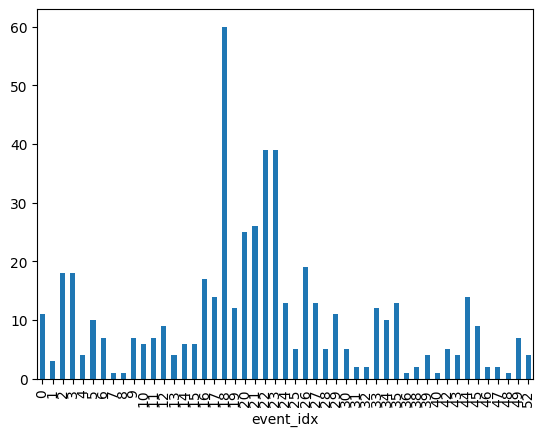

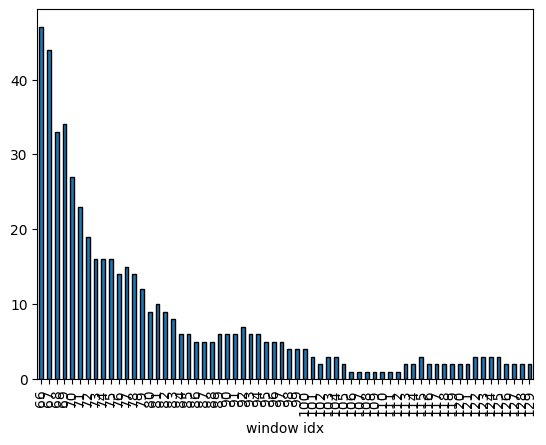

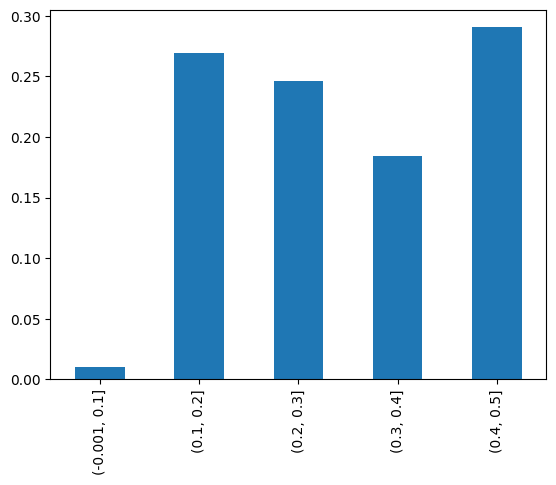

In [67]:
# df and plots settings
pd.set_option("display.float_format", "{:.2%}".format)

pd.options.plotting.backend = "matplotlib"


# print(dataset_df)
pd.set_option("display.max_rows", 2000)
false_positive = dataset_df.query('Result == "FP"')
false_negative = dataset_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])

false_positive_plot = false_positive.groupby(["window idx"])["window idx"].count()
false_negative_plot = false_negative.groupby(["window idx"])["window idx"].count()
# print(false_positive['Pred probability'].value_counts(bins=10, sort=False))


if len(false_positive_plot) > 0:
    print("FALSE POSITVES")
    print(false_positive)
    # print(false_positive.groupby(['event_idx'])['event_idx'].count())
    false_positive.groupby(['event_idx'])['event_idx'].count().plot(kind='bar')
    plt.show()
    false_positive_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_positive["Pred probability"].value_counts(
        bins = [i * 0.1 for i in range(5, 11)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()
if len(false_negative_plot) > 0:
    print("FALSE NEGATIVES")
    print(false_negative)
    # print(false_negative.groupby(['event_idx'])['event_idx'].count())
    false_negative.groupby(['event_idx'])['event_idx'].count().plot(kind='bar')
    plt.show()

    false_negative_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_negative["Pred probability"].value_counts(
        bins = [i * 0.1 for i in range(6)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()




plt.show()


In [58]:
model.load_state_dict(torch.load('models\LSTMHarmonic_weights_R3Currents.pth'))
print(conf_matrix_total)
metrics = conf_matrix_metrics(conf_matrix_total)
print_metrics(metrics)
plot_confusion_matrix(metrics)


[2940    0 3564  516 3456]
Total windows:................7020
True Positives:...............2940
False Positives:..............   0
True Negatives:...............3564
False Negatives:.............. 516
Accuracy:.....................  92.6%
True Positive Rate:...........  85.1%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%


##### 7.6. Save Dataframe and Confusion Matrix

In [59]:
# dataset_df.to_parquet('parquet_data/ModelR2_currents_df.parquet')
# conf_matrix_df = pd.DataFrame(conf_matrix.cpu(), columns = ['TP','FP','TF', 'FN', 'TP + FN'])
# conf_matrix_df.to_parquet('parquet_data/ModelR2_currents_CM_df.parquet')
# np.save('parquet_data/ModelR2_currents_CM.npy', conf_matrix.cpu())

##### 7.7. Individual Sample Visualization

C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R1\Fault01_B124_RF20.csv
256
(256, 0)


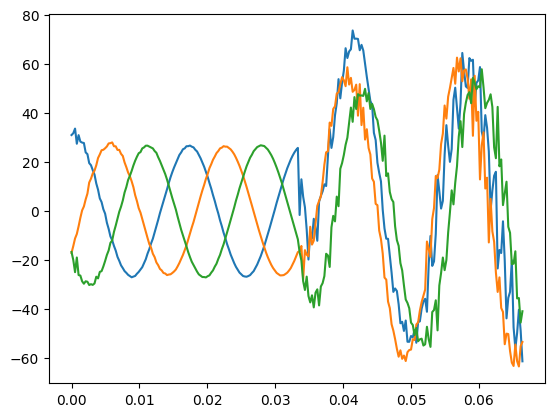

Confusion Matrix: tensor([[62,  0, 66,  2, 64]], device='cuda:0')
     event_idx  Pred probability  Pred label  True label Result
0            2             6.29%           0           0     TN
1            2             5.70%           0           0     TN
2            2             6.84%           0           0     TN
3            2             9.14%           0           0     TN
4            2             9.96%           0           0     TN
5            2            10.06%           0           0     TN
6            2            10.23%           0           0     TN
7            2            10.44%           0           0     TN
8            2            10.74%           0           0     TN
9            2            11.36%           0           0     TN
10           2            11.88%           0           0     TN
11           2            12.95%           0           0     TN
12           2            13.76%           0           0     TN
13           2            15.17%      

FALSE POSITVES
Empty DataFrame
Columns: [event_idx, Pred probability, Pred label, True label, Result]
Index: []

FALSE NEGATIVES
    event_idx  Pred probability  Pred label  True label Result
66          2            33.70%           0           1     FN
67          2            43.27%           0           1     FN


In [70]:
# Create signal_df
event_idx = 2
print(dataset.csv_list[event_idx])
sample_df, conf_matrix = signal_exploration(event_idx, dataset, model)
metrics = conf_matrix_metrics(conf_matrix)
print(f"Confusion Matrix: {conf_matrix}")
print(sample_df)
plot_confusion_matrix(metrics)
false_positive = sample_df.query('Result == "FP"')
false_negative = sample_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])
print("FALSE POSITVES")
print(false_positive)
print("")
print("FALSE NEGATIVES")
print(false_negative)

In [71]:
def update_fig(fig):
    fig.update_traces(line_color="#EEEEEE", line_width=2)
    fig.update_layout(
        paper_bgcolor="#222831",
        plot_bgcolor="#393E46",
        font_color="whitesmoke",
    )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")


signal, t = dataset.__getitem__(2440, data_plot=True)
signal = signal.reshape((-1, 3))
signal = signal[:, 0]
# print(f"Window index: {sample_df.query('indices == 196').index[0]}")
fig = px.line(
    x=t,
    y=signal,
    width=600,
    height=400,
    labels=dict(x="time", y="Amplitude"),
)
# update_fig(fig)
fig.show()
fig = px.line(
    x=sample_df.index,
    y=sample_df["Pred label"],
    width=600,
    height=400,
    labels=dict(x="Window", y="Trip Signal"),
    line_shape="hv",
)
# update_fig(fig)
fig.show()

### 8. References
1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->